In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.spatial import ConvexHull, HalfspaceIntersection, QhullError
from scipy.optimize import linprog
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shapely.geometry import Point, MultiPoint, Polygon, LineString, GeometryCollection
from itertools import combinations
from matplotlib.patches import Polygon

def ZTukeyMed(X, i, plot):
    """
    X: nx2 matrix 
    i: index of z
    plot: boolean, plot == True: generates plot. plot == false: no plot, just returns depth and z-median vertices
 
    """
    z = X[i]
    n = len(X)
    upper_klevels = []
    lower_klevels = []
    candidate_constraints = []
    
    indices = range(n)
    epsilon = 1e-9
    
    # Compute all k-levels
    for idx1, idx2 in combinations(indices, 2):
        p1 = X[idx1]
        p2 = X[idx2]
        dy = p2[1] - p1[1]
        dx = p2[0] - p1[0]
        a = -dy
        b = dx
        c = - (a * p1[0] + b * p1[1])
        
        # Check how many points above/below line
        vals = a * X[:, 0] + b * X[:, 1] + c
        
        n_above = np.sum(vals > epsilon)
        n_below = np.sum(vals < -epsilon)
        
        # Evaluate z position
        z_val = a * z[0] + b * z[1] + c
        z_is_above = z_val > epsilon
        z_is_below = z_val < -epsilon
        z_on_line  = abs(z_val) <= epsilon
        
        # Case 1: Less points above, keep lower halfspace
        if n_above < n_below:
            k = n_above
            if z_is_below or z_on_line:
                candidate_constraints.append((k, a, b, c, 0))
                if k == n/2-1:
                    upper_klevels.append(["num above: ", n_above, "p1: ", p1, " p2: ", p2])

        # Case 2: fewer points below, keep upper halfspace
        elif n_below < n_above:
            k = n_below
            if z_is_above or z_on_line:
                candidate_constraints.append((k, -a, -b, -c, 0))
                if k == n/2-1:
                    lower_klevels.append(["num below: ", n_below, "p1: ", p1, " p2: ", p2])

        # Case 3: Equal number above and below
        else:
            k = n_above
            if z_is_above:
                candidate_constraints.append((k, -a, -b, -c, 0))
            elif z_is_below:
                candidate_constraints.append((k, a, b, c, 0))
            else:
                # d=1: Intersect with line itself
                if (n%2 == 0):
                    candidate_constraints.append((k, a, b, c, 1)) 

    if not candidate_constraints:
        print("No valid constraints found.")
        return 0, np.array([]), [], []

    # find median depth
    max_k = max(item[0] for item in candidate_constraints)
    median_found = False
    final_poly = np.array([]) 

    while (not median_found) and (max_k >= 0):
        active_constraints = [item for item in candidate_constraints if item[0] <= max_k]
        
        inf = 1e9
        poly = np.array([[-inf, -inf], [inf, -inf], [inf, inf], [-inf, inf]])
        
        def clip_polygon(poly, a, b, c, d):
            new_poly = []
            if len(poly) == 0: return new_poly
            
            # d=1: Intersect with line ax+by+c=0
            if d == 1:
                for j in range(len(poly)):
                    p_curr = poly[j]
                    p_next = poly[(j + 1) % len(poly)]
                    
                    val_curr = a * p_curr[0] + b * p_curr[1] + c
                    val_next = a * p_next[0] + b * p_next[1] + c
                    
                    # If point is on the line, keep it
                    if abs(val_curr) <= 1e-9:
                        new_poly.append(p_curr)
                        
                    # If edge crosses the line (strict crossing), add intersection
                    if (val_curr < -1e-9 and val_next > 1e-9) or \
                       (val_curr > 1e-9 and val_next < -1e-9):
                        denom = val_curr - val_next
                        if abs(denom) > 1e-12:
                            t = val_curr / denom
                            inter_p = p_curr + t * (p_next - p_curr)
                            new_poly.append(inter_p)
                return np.array(new_poly)

            # d=0: Clip against halfspace ax+by+c <= 0
            else:
                for j in range(len(poly)):
                    p_curr = poly[j]
                    p_next = poly[(j + 1) % len(poly)]
                    
                    val_curr = a * p_curr[0] + b * p_curr[1] + c
                    val_next = a * p_next[0] + b * p_next[1] + c
                    
                    # Keep points inside
                    if val_curr <= 1e-9:
                        new_poly.append(p_curr)
                    # Add intersection if crossing boundary
                    if (val_curr <= 1e-9 and val_next > 1e-9) or (val_curr > 1e-9 and val_next <= 1e-9):
                        denom = val_curr - val_next
                        if abs(denom) > 1e-12:
                            t = val_curr / denom
                            inter_p = p_curr + t * (p_next - p_curr)
                            new_poly.append(inter_p)
                return np.array(new_poly)
    
        # Apply constraints
        for _, a, b, c, d in active_constraints:
            if a == 0 and b == 0: continue
            poly = clip_polygon(poly, a, b, c, d)
            if len(poly) == 0: break 
        
        if len(poly) > 0:
            min_x, max_x = np.min(poly[:,0]), np.max(poly[:,0])
            min_y, max_y = np.min(poly[:,1]), np.max(poly[:,1])
            
            width = max_x - min_x
            height = max_y - min_y
            
            is_singular = (width < 1e-6) and (height < 1e-6)
            
            if not is_singular:
                median_found = True
                final_poly = poly
            else:
                max_k -= 1
        else:
            max_k -= 1

    # --- PLOTTING ---
    if (plot):
        plt.figure(figsize=(8, 8))
        plt.scatter(X[:,0], X[:,1], c='blue', alpha=0.6, label='Neighbors')
        plt.scatter(z[0], z[1], c='red', marker='*', s=200, zorder=10, label='Agent z')
        
        if len(final_poly) > 0:
            # Check if it's a line segment (2 points) or polygon
            plot_poly = np.vstack([final_poly, final_poly[0]])
            plt.plot(plot_poly[:,0], plot_poly[:,1], 'g-', linewidth=2, label=f'Z-Tukey median (k={max_k+1})')
            if len(final_poly) > 2:
                plt.fill(plot_poly[:,0], plot_poly[:,1], 'g', alpha=0.2)
        else:
            print(f"Region for k={max_k} is empty or singular.")
    
        plt.title(f"Z-Constrained Tukey Median \nMax Depth k={max_k+1}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend(loc='best')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.axis('equal')
        
        x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
        y_min, y_max = np.min(X[:,1]), np.max(X[:,1])
        buff = (x_max - x_min) * 0.2 + 0.5
        plt.xlim(x_min - buff, x_max + buff)
        plt.ylim(y_min - buff, y_max + buff)
        plt.show()
    
    return max_k+1, final_poly
def ZTukeyMed3D(X, i, plot=True):
    """
    X: nx3 matrix of points
    i: index of agent z
    plot: boolean, generates 3D plot if True
    """
    z = X[i]
    n = len(X)
    candidate_constraints = []
    
    indices = range(n)
    epsilon = 1e-6
    
    # --- STEP 1: Generate Planes and Constraints ---
    # In 3D, a plane is defined by 3 points
    for idx1, idx2, idx3 in combinations(indices, 3):
        p1, p2, p3 = X[idx1], X[idx2], X[idx3]
        
        # Vector p1->p2 and p1->p3
        v1 = p2 - p1
        v2 = p3 - p1
        
        # Normal vector (cross product) = [a, b, c]
        normal = np.cross(v1, v2)
        norm_mag = np.linalg.norm(normal)
        
        # Skip collinear points
        if norm_mag < epsilon:
            continue
            
        a, b, c = normal
        # Plane eq: ax + by + cz + d = 0 => d = -(ax + by + cz)
        d_coeff = -np.dot(normal, p1)
        
        # Evaluate all points against plane
        # vals > 0: "Above", vals < 0: "Below"
        vals = a * X[:, 0] + b * X[:, 1] + c * X[:, 2] + d_coeff
        
        n_above = np.sum(vals > epsilon)
        n_below = np.sum(vals < -epsilon)
        
        # Evaluate z position
        z_val = a * z[0] + b * z[1] + c * z[2] + d_coeff
        z_is_above = z_val > epsilon
        z_is_below = z_val < -epsilon
        z_on_plane = abs(z_val) <= epsilon
        
        # Logic mirroring your 2D code:
        # We keep the "Deep" halfspace (the one with MORE points),
        # but ONLY if Z is in that halfspace (or on boundary).
        
        # Case 1: Fewer points above -> "Below" is the deep side
        if n_above < n_below:
            k = n_above
            # If Z is in the deep side (below) or on plane, add constraint
            # Constraint: Must be on "Below" side => ax+by+cz+d <= 0
            if z_is_below or z_on_plane:
                candidate_constraints.append((k, a, b, c, d_coeff))

        # Case 2: Fewer points below -> "Above" is the deep side
        elif n_below < n_above:
            k = n_below
            # If Z is in the deep side (above) or on plane, add constraint
            # Constraint: Must be on "Above" side => -(ax+by+cz+d) <= 0
            if z_is_above or z_on_plane:
                candidate_constraints.append((k, -a, -b, -c, -d_coeff))

        # Case 3: Balanced
        else:
            k = n_above
            if z_is_above:
                candidate_constraints.append((k, -a, -b, -c, -d_coeff))
            elif z_is_below:
                candidate_constraints.append((k, a, b, c, d_coeff))
            # If z on plane, usually in 3D we don't add a singular constraint 
            # unless we want to restrict to a 2D plane, which complicates finding volumes.
            # We skip the specific 'd=1' singular case for 3D volume finding.

    if not candidate_constraints:
        print("No valid constraints found.")
        return 0, np.array([])

    # --- STEP 2: Solve for Median Region ---
    max_k = max(item[0] for item in candidate_constraints)
    median_vertices = np.array([])
    median_found = False
    
    # Iterate depth k downwards until we find a non-empty region
    while (not median_found) and (max_k >= 0):
        active = [item for item in candidate_constraints if item[0] <= max_k]
    
        if not active:
            max_k -= 1
            continue
    
        halfspaces = np.array([[item[1], item[2], item[3], item[4]] for item in active])
        hs_A = halfspaces[:, :3]
        hs_b = halfspaces[:, 3]
    
        # --- FIX: Chebyshev center to guarantee a strictly interior point ---
        # Variables: [x0, x1, x2, s]
        # For each halfspace a_i·x + b_i <= 0, enforce a_i·x + ||a_i||*s <= -b_i
        # Maximize s (i.e., minimize -s) to get deepest interior point
        row_norms = np.linalg.norm(hs_A, axis=1, keepdims=True)  # shape (m, 1)
        A_cheb = np.hstack([hs_A, row_norms])                    # shape (m, 4)
        b_cheb = -hs_b                                            # shape (m,)
        c_cheb = np.array([0.0, 0.0, 0.0, -1.0])                 # minimize -s
    
        res = linprog(
            c=c_cheb,
            A_ub=A_cheb,
            b_ub=b_cheb,
            bounds=[(None, None), (None, None), (None, None), (0, None)],
            method='highs'
        )
    
        if not res.success or res.x[3] < epsilon:
           
            max_k -= 1
            continue
    
        feasible_point = res.x[:3]
    
        try:
            hs_intersection = HalfspaceIntersection(halfspaces, feasible_point)
            median_vertices = hs_intersection.intersections
    
            if len(median_vertices) >= 3:
                median_found = True
            else:
                max_k -= 1
        except QhullError as e:
           # print(f"QhullError at depth {max_k}: {e}")
            max_k -= 1

    # --- PLOTTING ---
    if plot:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot Neighbors
        ax.scatter(X[:,0], X[:,1], X[:,2], c='blue', alpha=0.3, label='Neighbors')
        # Plot Z
        ax.scatter(z[0], z[1], z[2], c='red', marker='*', s=200, label='Agent z', depthshade=False)
        if median_found and len(median_vertices) > 0:
            # Case A: 3 points (Triangle) - Plot directly
            if len(median_vertices) == 3:
                # Close the loop for the edge plot
                tri_edges = np.vstack([median_vertices, median_vertices[0]])
                ax.plot(tri_edges[:, 0], tri_edges[:, 1], tri_edges[:, 2], 'g-', linewidth=2)
                
                # Create a single face
                poly3d = Poly3DCollection([median_vertices], alpha=0.25, facecolors='green', edgecolors='green')
                ax.add_collection3d(poly3d)

            # Case B: 4+ points - Try ConvexHull, fall back if coplanar
            else:
                try:
                    # Try to create a 3D hull
                    hull = ConvexHull(median_vertices)
                    
                    # Plot edges
                    for simplex in hull.simplices:
                        ax.plot(median_vertices[simplex, 0], median_vertices[simplex, 1], median_vertices[simplex, 2], 'g-')
                    
                    # Plot faces
                    faces = [median_vertices[s] for s in hull.simplices]
                    poly3d = Poly3DCollection(faces, alpha=0.25, facecolors='green', edgecolors='green')
                    ax.add_collection3d(poly3d)
                    
                except Exception:
                    # Fallback for Coplanar/Flat polygons with >3 points
                    # (QhullError: "less than 4-dimensional" or similar)
                   # print("Region is flat (coplanar). Plotting as vertices.")
                    
                    # Simple centroid sort to try and plot a clean polygon (optional)
                    # For now, just plot the edges connecting points in generic order or just the points
                    center = np.mean(median_vertices, axis=0)
                    # Plot points
                    ax.scatter(median_vertices[:,0], median_vertices[:,1], median_vertices[:,2], c='green', s=50)
                    
                    # Try to plot a single face if points are roughly ordered
                    # (Note: HalfspaceIntersection doesn't guarantee order, so this might look messy without a sorter)
                    poly3d = Poly3DCollection([median_vertices], alpha=0.25, facecolors='green')
                    ax.add_collection3d(poly3d)
                
           # except Exception as e:
            #    print(f"Plotting error (likely flat polygon): {e}")
        else:
            print(f"No non-empty region found for k={max_k}")

        ax.set_title(f"3D Z-Tukey Median (Max Depth k={max_k+1})")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # Auto-scaling
        all_points = np.vstack([X, median_vertices]) if len(median_vertices) > 0 else X
        ax.set_xlim(all_points[:,0].min(), all_points[:,0].max())
        ax.set_ylim(all_points[:,1].min(), all_points[:,1].max())
        ax.set_zlim(all_points[:,2].min(), all_points[:,2].max())
        
        plt.legend()
        plt.show()

    return max_k+1, median_vertices
def TukeyMed(X,plot):
    """
    X: nx2 matrix
    plot: boolean for plotting options
    """
    n = len(X)
    
    # Store tuples of (k, a, b, c) representing constraint ax + by + c <= 0
    candidate_constraints = []
    
    indices = range(n)
    epsilon = 1e-9
    
    # 1. Loop through all pairs
    for idx1, idx2 in combinations(indices, 2):
        p1 = X[idx1]
        p2 = X[idx2]
        
        # Line formulation: A*x + B*y + C = 0
        dy = p2[1] - p1[1]
        dx = p2[0] - p1[0]
        a = -dy
        b = dx
        c = - (a * p1[0] + b * p1[1])
        
        # Evaluate points
        vals = a * X[:, 0] + b * X[:, 1] + c
        
        n_above = np.sum(vals > epsilon)
        n_below = np.sum(vals < -epsilon)
        

        k = min(n_above, n_below)

        if n_above < n_below:
            # Constraint: val <= 0 -> ax + by + c <= 0
            candidate_constraints.append((k, a, b, c))
            
        # Case B: Below is smaller -> Keep ABOVE
        elif n_below < n_above:
            # Constraint: val >= 0 -> -val <= 0 -> -ax -by -c <= 0
            candidate_constraints.append((k, -a, -b, -c))
            
        # Case C: Equal parts
        else:

            candidate_constraints.append((k, a, b, c))   # Keep Below
            candidate_constraints.append((k, -a, -b, -c)) # Keep Above

    if not candidate_constraints:
        print("No valid constraints found.")
        return 0

    # 4. Find the highest k
    max_k = max(item[0] for item in candidate_constraints)
    median_found = False
    while (not median_found):
    # Filter constraints for this max k
        active_constraints = [item for item in candidate_constraints if item[0] == max_k]
        
        # 5. Compute Intersection
        inf = 1e9
        poly = np.array([[-inf, -inf], [inf, -inf], [inf, inf], [-inf, inf]])
        
        def clip_polygon(poly, a, b, c):
            new_poly = []
            if len(poly) == 0: return new_poly
            
            for j in range(len(poly)):
                p_curr = poly[j]
                p_next = poly[(j + 1) % len(poly)]
                
                val_curr = a * p_curr[0] + b * p_curr[1] + c
                val_next = a * p_next[0] + b * p_next[1] + c
                
                if val_curr <= 1e-9:
                    new_poly.append(p_curr)
                
                if (val_curr <= 1e-9 and val_next > 1e-9) or (val_curr > 1e-9 and val_next <= 1e-9):
                    denom = val_curr - val_next
                    if abs(denom) > 1e-12:
                        t = val_curr / denom
                        inter_p = p_curr + t * (p_next - p_curr)
                        new_poly.append(inter_p)
            return np.array(new_poly)
    
        for _, a, b, c in active_constraints:
            poly = clip_polygon(poly, a, b, c)
        if len(poly) > 0:
            median_found = True
        else:
            max_k = max_k-1
        # --- PLOTTING ---
        if plot:
            if len(poly) > 0:
                plt.figure(figsize=(10, 10))
                plt.scatter(X[:,0], X[:,1], c='blue', alpha=0.6, label='Points')
                plot_poly = np.vstack([poly, poly[0]])
                plt.plot(plot_poly[:,0], plot_poly[:,1], 'm-', linewidth=2, label=f'Tukey Median (k={max_k+1})')
                plt.fill(plot_poly[:,0], plot_poly[:,1], 'm', alpha=0.2)
                plt.title(f"Standard Tukey Median\nMax Depth k={max_k+1}")
                plt.xlabel("X")
                plt.ylabel("Y")
                plt.legend(loc='best')
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.axis('equal')
                
                x_min, x_max = np.min(X[:,0]), np.max(X[:,0])
                y_min, y_max = np.min(X[:,1]), np.max(X[:,1])
                buff = (x_max - x_min) * 0.2 + 0.5
                plt.xlim(x_min - buff, x_max + buff)
                plt.ylim(y_min - buff, y_max + buff)
                plt.savefig("Tukey.jpg")
                plt.show()
    
    return max_k+1,poly

def update_resilient_layers(current_N, all_positions, step_size,step_size_hull):
    next_N = current_N.copy()
    n = len(all_positions)
    dim = len(current_N[0,:])
    # 1. Compute the global convex hull
    hull = ConvexHull(all_positions)
    hull_indices = hull.vertices # Indices of points on the global boundary
    f = n - len(current_N)
    # 2. Identify Normal nodes on the hull
    # all_positions[:len(current_N)] are the normal nodes
    if dim ==2:
        if n%2 ==0:
            thresh = n/2
        else:
            thresh = np.ceil(n/2)-1
    if dim == 3:
        thresh = np.floor(n/3)
    normal_on_hull = [i for i in hull_indices if i < len(current_N)]
    
    for i in range(len(current_N)):
        pos = current_N[i]
        if dim ==2:
            depth, targets = ZTukeyMed(all_positions, i,False)
        if dim ==3: 
            depth, targets = ZTukeyMed3D(all_positions,i,False)
        comp = True
        mask = np.all(np.abs(targets)<10, axis = 1)
        targets = targets[mask]
        # check to see if we have real coordinates or precision-error noise
        if comp :#and depth> f:
            if i in normal_on_hull:
                # Outermost nodes move faster to 'push' the interior
                current_step = step_size_hull
            else:
                # Interior nodes move slower to wait for hull reconfiguration
                current_step = step_size#+float(np.random.randn(1))*.01

            if  len(targets)>1:
                # diffs = targets - pos
                # angles = np.arctan2(diffs[:,1],diffs[:,0])
                # last_vertex_idx = np.argmin(angles)
                far = 0
                far_idx = 0
  
                for j in range(len(targets)):
                    dist = np.linalg.norm(targets[j]-pos)
                    if dist>far:
                        far = dist
                        far_idx = j
                target_pos = targets[far_idx]
            else:
                d, targets = TukeyMedian(all_positions,False)
                if len(targets)>1:
                    target_pos = np.mean(targets,axis=0)
                else:
                    targetpos = pos
                
            next_N[i] += (target_pos - pos) * current_step
        else: 
            continue
        
           # print("targets: ", targets)
        
    return next_N
def PlotBoundedCells(X_n,X_f, ax=None):
    """
    Computes and plots the union of bounded cells formed by the arrangement 
    of strict halving lines.
    """
    X = np.vstack([X_n,X_f])
    n = len(X)
    
    # compute bisecting lines
    # --------------------------------
    if n % 2 == 0:
        target_count = (n - 2) // 2
    else:
        target_count = (n - 1) // 2 - 1
        
    lines = [] # Tuples of (a, b, c)
    epsilon = 1e-9
    
    for idx1, idx2 in combinations(range(n), 2):
        p1, p2 = X[idx1], X[idx2]
        dy, dx = p2[1] - p1[1], p2[0] - p1[0]
        a, b = -dy, dx
        c = - (a * p1[0] + b * p1[1])
        
        vals = a * X[:, 0] + b * X[:, 1] + c
        n_above = np.sum(vals > epsilon)
        n_below = np.sum(vals < -epsilon)
        
        if n_above == target_count or n_below == target_count:
            lines.append((a, b, c))

    if not lines:
        print("No halving lines found.")
        return

    # Calculate intersections to size the box appropriately
    intersections = []
    for l1, l2 in combinations(lines, 2):
        a1, b1, c1 = l1
        a2, b2, c2 = l2
        det = a1 * b2 - a2 * b1
        if abs(det) > 1e-9:
            px = (b1 * c2 - b2 * c1) / det
            py = (c1 * a2 - c2 * a1) / det
            intersections.append([px, py])
            
    data_min_x, data_max_x = np.min(X[:, 0]), np.max(X[:, 0])
    data_min_y, data_max_y = np.min(X[:, 1]), np.max(X[:, 1])

    # 2. Get bounds of the intersections (if they exist)
    if intersections:
        pts = np.array(intersections)
        int_min_x, int_max_x = np.min(pts[:,0]), np.max(pts[:,0])
        int_min_y, int_max_y = np.min(pts[:,1]), np.max(pts[:,1])
        
        # 3. Take the union of data bounds and intersection bounds
        # This ensures the box covers BOTH the arrangement and the points
        min_x = min(data_min_x, int_min_x)
        max_x = max(data_max_x, int_max_x)
        min_y = min(data_min_y, int_min_y)
        max_y = max(data_max_y, int_max_y)
    else:
        # Fallback if lines are parallel (use data bounds)
        min_x, max_x = data_min_x, data_max_x
        min_y, max_y = data_min_y, data_max_y

    # 4. Add buffer (margin)
    # Calculated based on the total spread
    buff_x = (max_x - min_x) * 0.5 + 1.0 
    buff_y = (max_y - min_y) * 0.5 + 1.0
    
    # Define the calculation box (used for DCEL walls)
    box = [min_x - buff_x, max_x + buff_x, min_y - buff_y, max_y + buff_y]
    
    bx_min, bx_max, by_min, by_max = box
    box_lines = [
        (1, 0, -bx_min), (1, 0, -bx_max), # x = min, x = max
        (0, 1, -by_min), (0, 1, -by_max)  # y = min, y = max
    ]
    all_lines = lines + box_lines
    
    faces = compute_arrangement_faces(all_lines, box)
    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
        
    # Plot Points
    ax.scatter(X_n[:, 0], X_n[:, 1], c='blue', zorder=10)
    ax.scatter(X_f[:, 0], X_f[:, 1], c='red', zorder=10)

    # Plot Halving Lines
    for a, b, c in lines:
        if abs(b) > 1e-6:
            x0, x1 = bx_min, bx_max
            y0 = (-c - a * x0) / b
            y1 = (-c - a * x1) / b
        else:
            x0 = -c / a
            x1 = x0
            y0, y1 = by_min, by_max
        ax.plot([x0, x1], [y0, y1], 'k-', alpha=0.6, linewidth=1)

    # Plot Bounded Cells (Orange Shading)
    found_bounded = False
    for face in faces:
        # Check if face touches the bounding box
        on_boundary = False
        for px, py in face:
            # Check proximity to box edges
            if (abs(px - bx_min) < 1e-5 or abs(px - bx_max) < 1e-5 or 
                abs(py - by_min) < 1e-5 or abs(py - by_max) < 1e-5):
                on_boundary = True
                break
        
        if not on_boundary:
            found_bounded = True
            poly = Polygon(face, facecolor='orange', edgecolor='darkorange', alpha=0.6, zorder=5)
            ax.add_patch(poly)

    ax.set_title(f"Union of Bounded Cells (Halving Lines)\nPoints: {n}")
    ax.set_xlim(bx_min + buff_x*0.2, bx_max - buff_x*0.2)
    ax.set_ylim(by_min + buff_y*0.2, by_max - buff_y*0.2)
    ax.set_aspect('equal')
    
    if not found_bounded:
        ax.text(np.mean(X[:,0]), np.mean(X[:,1]), "No Bounded Cells\n(Empty Void)", 
                ha='center', va='center', color='red', fontweight='bold')
    
    if ax is None:
        plt.show()

def compute_arrangement_faces(lines, box):
    """
    Computes faces of a line arrangement within a bounding box using a 
    doubly-connected edge list (DCEL) simplified approach.
    """
    intersections = []
    segments_on_line = {i: [] for i in range(len(lines))}
    
    for i, j in combinations(range(len(lines)), 2):
        l1, l2 = lines[i], lines[j]
        a1, b1, c1 = l1
        a2, b2, c2 = l2
        det = a1 * b2 - a2 * b1
        if abs(det) > 1e-9:
            px = (b1 * c2 - b2 * c1) / det
            py = (c1 * a2 - c2 * a1) / det
            
            # Check bounds
            if (box[0]-1e-5 <= px <= box[1]+1e-5) and (box[2]-1e-5 <= py <= box[3]+1e-5):
                if abs(b1) > abs(a1): t1 = px 
                else: t1 = py
                
                if abs(b2) > abs(a2): t2 = px 
                else: t2 = py
                
                segments_on_line[i].append((t1, px, py))
                segments_on_line[j].append((t2, px, py))

    adj = {} 
    
    def add_edge(p_start, p_end):
        p1 = tuple(np.round(p_start, 5))
        p2 = tuple(np.round(p_end, 5))
        if p1 == p2: return
        
        if p1 not in adj: adj[p1] = []
        if p2 not in adj: adj[p2] = []
        
        angle1 = np.arctan2(p2[1] - p1[1], p2[0] - p1[0])
        angle2 = np.arctan2(p1[1] - p2[1], p1[0] - p2[0])

        if not any(np.allclose(x[0], p2) for x in adj[p1]):
            adj[p1].append((p2, angle1))
        if not any(np.allclose(x[0], p1) for x in adj[p2]):
            adj[p2].append((p1, angle2))

    for i in segments_on_line:
        pts = sorted(segments_on_line[i], key=lambda x: x[0])
        for k in range(len(pts) - 1):
            p_start = [pts[k][1], pts[k][2]]
            p_end = [pts[k+1][1], pts[k+1][2]]
            add_edge(p_start, p_end)

    for node in adj:
        adj[node].sort(key=lambda x: x[1])

    visited = set()
    faces = []
    
    for u in adj:
        neighbors = adj[u]
        for i, (v, angle_v) in enumerate(neighbors):
            if (u, v) in visited: continue
            
            # Start tracing a new face
            path = [u]
            curr, next_node = u, v
            
            while True:
                visited.add((curr, next_node))
                path.append(next_node)
                
                if next_node == u: break # Cycle closed

                nbrs = adj[next_node]
                
                back_angle = np.arctan2(curr[1] - next_node[1], curr[0] - next_node[0])
                idx = -1
                for k, (nbr, ang) in enumerate(nbrs):
                    if nbr == curr: # Coordinate check
                        idx = k
                        break
                
                # The next outgoing edge in the sorted list is the one strictly CCW
                next_idx = (idx - 1) % len(nbrs) # -1 for Left Turn (Interior Faces), +1 for Right Turn
                
                next_node_candidate = nbrs[next_idx][0]
                curr = next_node
                next_node = next_node_candidate
                
                if (curr, next_node) in visited and next_node != u:
                    # Hit a visited path that isn't the start (merge or error), abort
                    path = []
                    break
            
            if len(path) > 2:

                pts = np.array(path)
                area = 0.5 * np.sum(pts[:-1,0]*pts[1:,1] - pts[:-1,1]*pts[1:,0])

                if abs(area) > 1e-6:
                    faces.append(np.array(path[:-1])) # Remove duplicate end point

    return faces
    
def ZBagPlot(X, i, ax=None, plot=True):
    """
    Computes/plots the Z-constrained Bag Plot (zdepth contours) and highlights the Z-Tukey median.
        X: nx2 matrix of points
        i: the index of z
    Returns:
        max_depth (int): The k-value of the median region.
        median_vertices (np.array): vertices of the Z-Tukey median 
    """
    z = X[i]
    n = len(X)
    epsilon = 1e-9
    
    # initialize list of constraints (halfspaces)
    candidate_constraints = []
    
    for idx1, idx2 in combinations(range(n), 2):
        p1, p2 = X[idx1], X[idx2]
        
        
        dy, dx = p2[1] - p1[1], p2[0] - p1[0]
        a, b, c = -dy, dx, -( -dy * p1[0] + dx * p1[1] )
        
        vals = a * X[:, 0] + b * X[:, 1] + c
        n_above = np.sum(vals > epsilon)
        n_below = np.sum(vals < -epsilon)
        
        z_val = a * z[0] + b * z[1] + c
        z_is_above = z_val > epsilon
        z_is_below = z_val < -epsilon
        z_on_line  = abs(z_val) <= epsilon
        
        # 
        constraint = None
        
        # case 1: fewer points above -> keep lower halfspace if it contains z
        if n_above < n_below:
            if z_is_below or z_on_line:
                constraint = (n_above, a, b, c,0)
        
        # case 2: fewer points below -> keep upper halfspace if it contains z
        elif n_below < n_above:
            if z_is_above or z_on_line:
                constraint = (n_below, -a, -b, -c,0)
        
        # case 3: equal -> keep halfspace that contains z
        else:
            k = n_above
            if z_is_above:
                constraint =(k, -a, -b, -c, 0)
            elif z_is_below:
                constraint =(k, a, b, c, 0)
            else:
                # d=1: Intersect with line itself
                if (n%2 == 0):
                    constraint =(k, a, b, c, 1)
                
        if constraint:
            candidate_constraints.append(constraint)


    median_vertices = np.empty((0, 2))
    if not candidate_constraints:
        print("No constraints found.")
        return 0, median_vertices

    unique_ks = sorted(list(set(item[0] for item in candidate_constraints)))
    
    levels_polys = [] # list of (depth, polygon vertices)
    

    def clip_polygon(poly, a, b, c, d):
            new_poly = []
            if len(poly) == 0: return new_poly
            
            # d=1: Intersect with line ax+by+c=0
            if d == 1:
                for j in range(len(poly)):
                    p_curr = poly[j]
                    p_next = poly[(j + 1) % len(poly)]
                    
                    val_curr = a * p_curr[0] + b * p_curr[1] + c
                    val_next = a * p_next[0] + b * p_next[1] + c
                    
                    # If point is on the line, keep it
                    if abs(val_curr) <= 1e-9:
                        new_poly.append(p_curr)
                        
                    # If edge crosses the line (strict crossing), add intersection
                    if (val_curr < -1e-9 and val_next > 1e-9) or \
                       (val_curr > 1e-9 and val_next < -1e-9):
                        denom = val_curr - val_next
                        if abs(denom) > 1e-12:
                            t = val_curr / denom
                            inter_p = p_curr + t * (p_next - p_curr)
                            new_poly.append(inter_p)
                return np.array(new_poly)

            # d=0: Clip against halfspace ax+by+c <= 0
            else:
                for j in range(len(poly)):
                    p_curr = poly[j]
                    p_next = poly[(j + 1) % len(poly)]
                    
                    val_curr = a * p_curr[0] + b * p_curr[1] + c
                    val_next = a * p_next[0] + b * p_next[1] + c
                    
                    # Keep points inside
                    if val_curr <= 1e-9:
                        new_poly.append(p_curr)
                    # Add intersection if crossing boundary
                    if (val_curr <= 1e-9 and val_next > 1e-9) or (val_curr > 1e-9 and val_next <= 1e-9):
                        denom = val_curr - val_next
                        if abs(denom) > 1e-12:
                            t = val_curr / denom
                            inter_p = p_curr + t * (p_next - p_curr)
                            new_poly.append(inter_p)
                return np.array(new_poly)

    # compute region for every depth level
    for k_threshold in unique_ks:
        depth = k_threshold + 1
        active_subset = [item for item in candidate_constraints if item[0] <= k_threshold]
        
        inf = 1e9
        poly = np.array([[-inf, -inf], [inf, -inf], [inf, inf], [-inf, inf]])
        
        for _, a, b, c,d in active_subset:
            if len(poly) == 0: break
            poly = clip_polygon(poly, a, b, c,d)
            
        # store if valid area
        if len(poly) > 0:
             w = np.max(poly[:,0]) - np.min(poly[:,0])
             h = np.max(poly[:,1]) - np.min(poly[:,1])
             if w > 1e-6 and h > 1e-6:
                 levels_polys.append((depth, poly))
    
    # Extract the median 
    max_depth = 0
    if levels_polys:
        max_depth = levels_polys[-1][0]
        median_vertices = levels_polys[-1][1]

    # plotting
    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
 
        ax.scatter(X[:,0], X[:,1], c='blue', s=13, alpha=1, label='X', zorder=100)

        if levels_polys:
            min_d = levels_polys[0][0]
            range_d = max_depth - min_d if max_depth > min_d else 1
            
            for depth, poly in levels_polys:
                intensity = (depth - min_d) / range_d
                fill_color = plt.cm.Blues(0.2 + 0.6 * intensity)
                
                # contour
                p = Polygon(poly, facecolor=fill_color, edgecolor=None, alpha=0.6, zorder=depth+10)
                ax.add_patch(p)

        # plot Z-Tukey median 
        if len(median_vertices) > 0:
            median_poly = np.vstack([median_vertices, median_vertices[0]])
            ax.plot(median_poly[:,0], median_poly[:,1], 
                    color='lime', linewidth=3, linestyle='-', 
                    label=f'Z-Median (k={max_depth})', zorder=200)
            
            # centroid of Z-median, probably not needed
            cx = np.mean(median_vertices[:,0])
            cy = np.mean(median_vertices[:,1])
           

        # plot z
        ax.scatter(z[0], z[1], c='red', marker='*', s=150, zorder=300, label='z')
        
        
        ax.set_title(f"Z-Constrained Bag Plot\n n = {n}, Max Depth k={max_depth}")
        ax.axis('equal')
        
       
        all_x, all_y = X[:,0], X[:,1]
        buff = (np.max(all_x) - np.min(all_x)) * 0.1
        ax.set_xlim(np.min(all_x) - buff, np.max(all_x) + buff)
        ax.set_ylim(np.min(all_y) - buff, np.max(all_y) + buff)
        ax.legend(loc='upper right')
        #plt.savefig("z-bagplot2.jpg")
        if ax is None:
            plt.show()

    return max_depth, median_vertices

In [2]:
def PlotBoundedCells(X_n, X_f,k, ax=None, xlimits =0, ylimits = 0, z = -1):
    """
    Computes and plots the union of bounded cells formed by the arrangement 
    of strict halving lines.
    
    MODIFIED: If n is odd, cells containing an input point as a vertex are excluded.
    """
    if z>= 0:
        mask= np.ones(len(X_n),dtype = bool)
        mask[z] = False
        X_t = X_n[mask]
        X = np.vstack([X_t,X_f])
        n = len(X)
    else:
        X = np.vstack([X_n, X_f])
        n = len(X)
    
    # compute bisecting lines
    # --------------------------------
    if n % 2 == 0:
        target_count = (n - 2) // 2
    else:
        target_count = (n - 1) // 2 - 1
    target_count = k-1     
    lines = [] # Tuples of (a, b, c)
    epsilon = 1e-9
    
    for idx1, idx2 in combinations(range(n), 2):
        p1, p2 = X[idx1], X[idx2]
        dy, dx = p2[1] - p1[1], p2[0] - p1[0]
        a, b = -dy, dx
        c = - (a * p1[0] + b * p1[1])
        
        vals = a * X[:, 0] + b * X[:, 1] + c
        n_above = np.sum(vals > epsilon)
        n_below = np.sum(vals < -epsilon)
        
        if n_above == target_count or n_below == target_count:
            lines.append((a, b, c))

    if not lines:
        print("No halving lines found.")
        return

    # Calculate intersections to size the box appropriately
    intersections = []
    for l1, l2 in combinations(lines, 2):
        a1, b1, c1 = l1
        a2, b2, c2 = l2
        det = a1 * b2 - a2 * b1
        if abs(det) > 1e-9:
            px = (b1 * c2 - b2 * c1) / det
            py = (c1 * a2 - c2 * a1) / det
            intersections.append([px, py])
            
    data_min_x, data_max_x = np.min(X[:, 0]), np.max(X[:, 0])
    data_min_y, data_max_y = np.min(X[:, 1]), np.max(X[:, 1])

    # 2. Get bounds of the intersections (if they exist)
    if intersections:
        pts = np.array(intersections)
        int_min_x, int_max_x = np.min(pts[:,0]), np.max(pts[:,0])
        int_min_y, int_max_y = np.min(pts[:,1]), np.max(pts[:,1])
        
        # 3. Take the union of data bounds and intersection bounds
        # This ensures the box covers BOTH the arrangement and the points
        min_x = min(data_min_x, int_min_x)
        max_x = max(data_max_x, int_max_x)
        min_y = min(data_min_y, int_min_y)
        max_y = max(data_max_y, int_max_y)
    else:
        # Fallback if lines are parallel (use data bounds)
        min_x, max_x = data_min_x, data_max_x
        min_y, max_y = data_min_y, data_max_y

    # 4. Add buffer (margin)
    # Calculated based on the total spread
    buff_x = (max_x - min_x) * 0.5 + 1.0 
    buff_y = (max_y - min_y) * 0.5 + 1.0
    
    # Define the calculation box (used for DCEL walls)
    box = [min_x - buff_x, max_x + buff_x, min_y - buff_y, max_y + buff_y]
    
    bx_min, bx_max, by_min, by_max = box
    box_lines = [
        (1, 0, -bx_min), (1, 0, -bx_max), # x = min, x = max
        (0, 1, -by_min), (0, 1, -by_max)  # y = min, y = max
    ]
    all_lines = lines + box_lines
    
    faces = compute_arrangement_faces(all_lines, box)
    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
        
    # Plot Points
    if z>= 0:
        ax.scatter(X_t[:, 0], X_t[:, 1], c='blue', zorder=10)
        ax.scatter(X_n[z, 0], X_n[z, 1], c='green', zorder=10)
    else:
        ax.scatter(X_n[:, 0], X_n[:, 1], c='blue', zorder=10)
    ax.scatter(X_f[:, 0], X_f[:, 1], c='red', zorder=10)

    # Plot Halving Lines
    for a, b, c in lines:
        if abs(b) > 1e-6:
            x0, x1 = bx_min, bx_max
            y0 = (-c - a * x0) / b
            y1 = (-c - a * x1) / b
        else:
            x0 = -c / a
            x1 = x0
            y0, y1 = by_min, by_max
        ax.plot([x0, x1], [y0, y1], 'k-', alpha=0.6, linewidth=1)

    # Plot Bounded Cells (Orange Shading)
    found_bounded = False
    for face in faces:
        # Check if face touches the bounding box
        on_boundary = False
        for px, py in face:
            # Check proximity to box edges
            if (abs(px - bx_min) < 1e-5 or abs(px - bx_max) < 1e-5 or 
                abs(py - by_min) < 1e-5 or abs(py - by_max) < 1e-5):
                on_boundary = True
                break
        
        if not on_boundary:
            should_plot = True
            
            # --- MODIFICATION START ---
            # If n is odd, check if the face contains any input point as a vertex
            if n % 2 != 0:
                for v_face in face:
                    # Euclidean distance check against all input points X
                    # Using broadcasting to check against the whole matrix
                    dists = np.linalg.norm(X - v_face, axis=1)
                    if np.any(dists < 1e-5):
                        should_plot = False
                        break
            # --- MODIFICATION END ---
            
            if should_plot:
                found_bounded = True
                poly = Polygon(face, facecolor='orange', edgecolor='darkorange', alpha=0.6, zorder=5)
                ax.add_patch(poly)
    if xlimits != 0 or ylimits!=0:
        ax.set_title(f"Union of Bounded Cells (Halving Lines)\nPoints: {n}")
        ax.set_xlim(-xlimits, xlimits)
        ax.set_ylim(-ylimits,ylimits)
    else:
        ax.set_title(f"Union of Bounded Cells (Halving Lines)\nPoints: {n}")
        ax.set_xlim(bx_min + buff_x*0.2, bx_max - buff_x*0.2)
        ax.set_ylim(by_min + buff_y*0.2, by_max - buff_y*0.2)
        ax.set_aspect('equal')
    
    if not found_bounded:
        ax.text(np.mean(X[:,0]), np.mean(X[:,1]), "No Bounded Cells\n(Empty Void)", 
                ha='center', va='center', color='red', fontweight='bold')
    
    if ax is None:
        plt.show()

Starting Simulation: 6 Normal vs 4 Adversarial


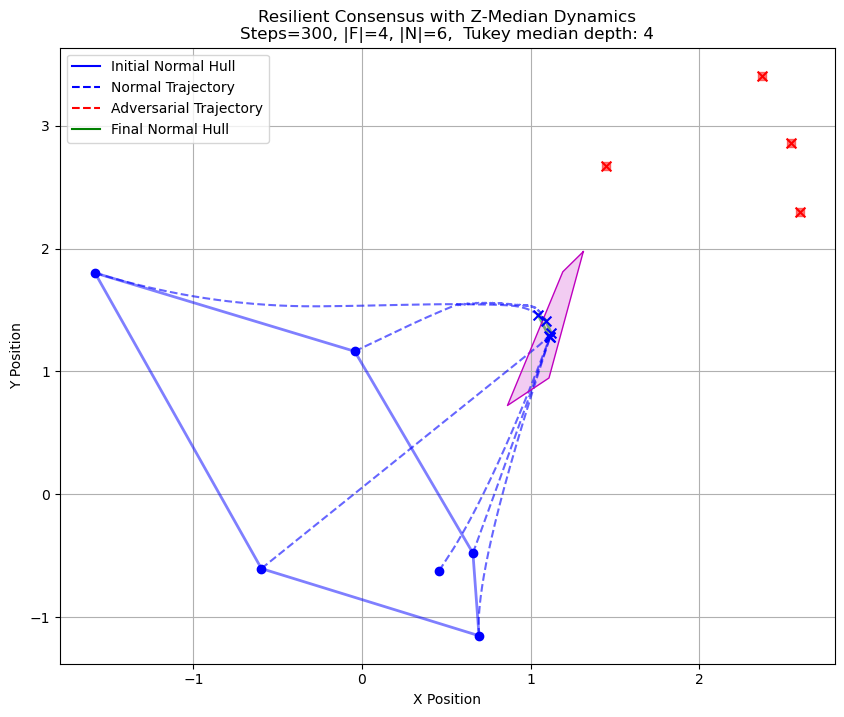

In [4]:
np.random.seed(86)
NUM_STEPS = 300
STEP_SIZE_HULL = .02
STEP_SIZE = .01


normal = 6
adversarial =4
n = normal+adversarial
#g1 = np.random.randn(int(normal/2), 2) *.8+np.array([-3,0])
#g2  =np.random.randn(int(normal/2), 2) *.8+np.array([3,0])
#N_nodes = np.vstack([g1,g2])
N_nodes = np.random.randn(normal, 2) *1 
#N_nodes = np.array(((-2,0),(0.5,0),(-1.5, 1),(3,-0.5),(1,0.3),(-1.5,.5)))
normal = len(N_nodes)
# Adversarial: 3 nodes starting slightly offset
F_nodes = np.random.randn(adversarial, 2) * .6 + np.array([2, 3]) 
#F_nodes = np.array(((0,3.5),(1.2,4),(-.6,3)))
adversarial = len(F_nodes)
# Target for adversaries 
adv_target = np.array(([0.0, 4.0],[0.0,6.0],[0,6.1]))

# History storage
history_N = [N_nodes.copy()]
history_F = [F_nodes.copy()]

# Simulation Loop

print(f"Starting Simulation: {len(N_nodes)} Normal vs {len(F_nodes)} Adversarial")

for t in range(NUM_STEPS):
    current_N = history_N[-1]
    current_F = history_F[-1]

    all_positions = np.vstack([current_N, current_F])
    # --- Update Normal Nodes ---
    #target[i] = []
    next_N = []

    next_N = update_resilient_layers(current_N, all_positions, STEP_SIZE,STEP_SIZE_HULL)

    next_F = []

    for i in range(len(current_F)):
        pos = current_F[i]
        #direction = adv_target[i] - pos
        #norm = np.linalg.norm(direction)
        #if norm > 0:
         #   move = (direction / norm) * STEP_SIZE * 4.5 # They move slightly faster
       # else:
           # move = np.zeros(2)
        #next_F.append(pos + move)
        #next_F.append(pos+(adv_target[1]-pos)*STEP_SIZE)
        next_F.append(pos)   
        # next_F = update_resilient_layers(current_F, all_positions, STEP_SIZE)
    # Store
    history_N.append(np.array(next_N))
    history_F.append(np.array(next_F))
    

history_N = np.array(history_N) 
history_F = np.array(history_F) 

fig, ax = plt.subplots(figsize=(10, 8))

# Plot Trajectories
# Normal Nodes (Blue)
for i in range(history_N.shape[1]):
    ax.plot(history_N[:, i, 0], history_N[:, i, 1], 'b--', alpha=0.6)
    ax.scatter(history_N[-1, i, 0], history_N[-1, i, 1], c='blue', s=50, marker = 'x',zorder=5) # End
    ax.scatter(history_N[0, i, 0], history_N[0, i, 1], c='blue', alpha=1) # Start

# Adversarial Nodes (Red)
for i in range(history_F.shape[1]):
    ax.plot(history_F[:, i, 0], history_F[:, i, 1], 'r--', alpha=0.6)
    ax.scatter(history_F[-1, i, 0], history_F[-1, i, 1], c='red', s=50, marker='x', zorder=5) # End
    ax.scatter(history_F[0, i, 0], history_F[0, i, 1], c='red', marker='s', alpha=0.5) # Start
X= np.vstack([history_N[0], history_F[0]])
depth, poly = TukeyMed(X,False)
# Annotations
ax.set_title(f"Resilient Consensus with Z-Median Dynamics\nSteps={NUM_STEPS}, |F|={adversarial}, |N|={normal},  Tukey median depth: {depth}")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")

# Plot convex hull of final and initial normal positions 

if len(history_N[-1]) >= 3:
    hull = ConvexHull(history_N[-1])
    for simplex in hull.simplices:
        ax.plot(history_N[-1, simplex, 0], history_N[-1, simplex, 1], 'g-', linewidth=2, alpha=0.5)
    hull2 = ConvexHull(history_N[0])
    for simplex in hull2.simplices:
        ax.plot(history_N[0, simplex, 0], history_N[0, simplex, 1], 'b-', linewidth=2, alpha=0.5)
# Legend dummy lines
ax.plot([],[],'b-', label = 'Initial Normal Hull')
ax.plot([],[], 'b--', label='Normal Trajectory')
ax.plot([],[], 'r--', label='Adversarial Trajectory')
ax.plot([],[], 'g-', label='Final Normal Hull')
ax.legend()

poly = np.vstack([poly, poly[0]])
plt.plot(poly[:,0], poly[:,1], 'm-', linewidth=1)
plt.fill(poly[:,0], poly[:,1], 'm', alpha=0.2)
plt.savefig("Zmed_example_1.jpg")           
plt.grid(True)
plt.show()

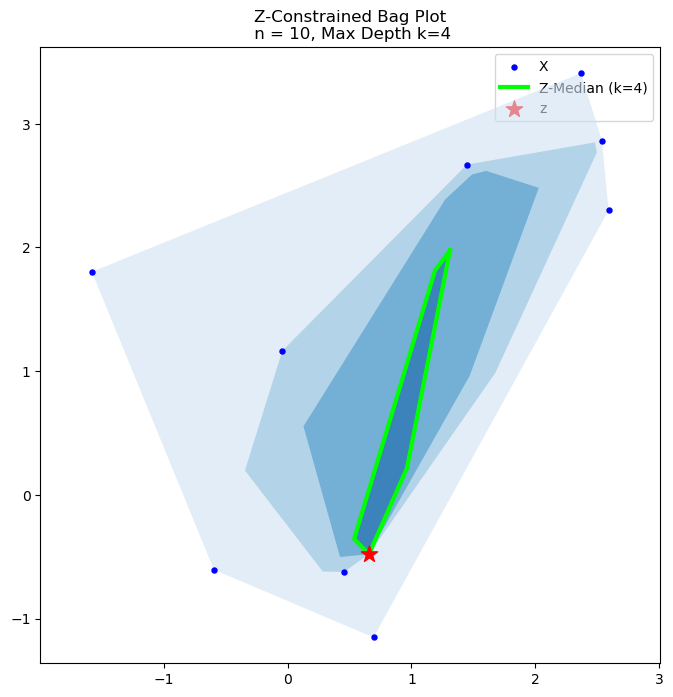

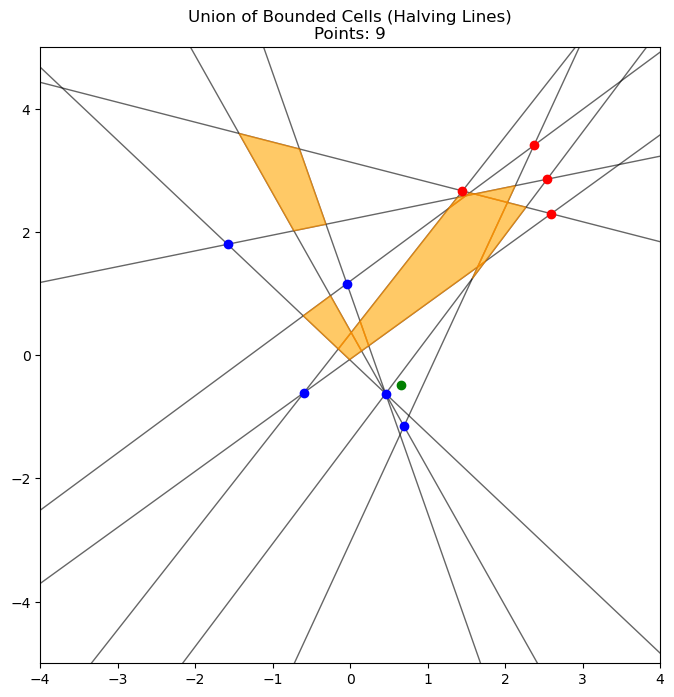

In [9]:
step = 0
X = np.vstack((history_N[step],history_F[step]))
#d,v = TukeyMed(X, True)
ind = 5
ZBagPlot(X,ind)
X_n = history_N[step]
X_f = history_F[step]
PlotBoundedCells(X_n, X_f,3, ax=None, xlimits =4, ylimits = 5, z = ind)

Starting Simulation: 7 Normal vs 2 Adversarial


NameError: name 'median_vertices' is not defined

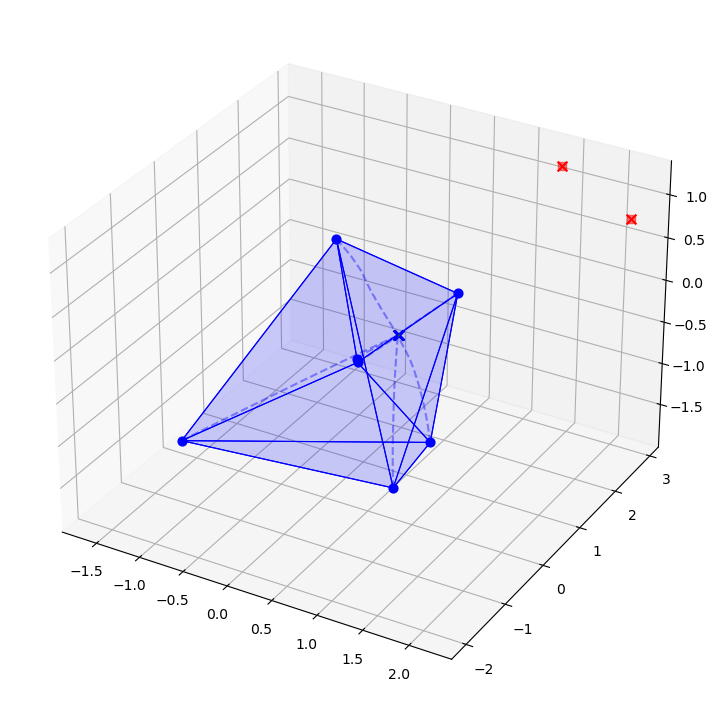

In [6]:
np.random.seed(55)
NUM_STEPS = 300
STEP_SIZE_HULL = .02
STEP_SIZE = .01
normal = 7
adversarial = 2
n = normal + adversarial

# --- 3D Node Initialization ---
N_nodes = np.random.randn(normal, 3) * 1.0
normal = len(N_nodes)

F_nodes = np.random.randn(adversarial, 3) * 0.6 + np.array([2, 3, 1])
adversarial = len(F_nodes)

# 3D adversarial targets (one per adversarial node, or just use one broadcast)
adv_target = np.array([
    [0.0, 4.0, 2.0],
    [0.0, 6.0, 1.5],
    [0.0, 6.1, 2.5],
    [0.5, 5.0, 3.0],
    [-.5, 5.5, 1.0]
])

# History storage
history_N = [N_nodes.copy()]
history_F = [F_nodes.copy()]

# --- Simulation Loop ---
print(f"Starting Simulation: {len(N_nodes)} Normal vs {len(F_nodes)} Adversarial")
for t in range(NUM_STEPS):
    current_N = history_N[-1]
    current_F = history_F[-1]
    all_positions = np.vstack([current_N, current_F])

    # Update Normal Nodes (your existing 3D-capable function)
    next_N = update_resilient_layers(current_N, all_positions, STEP_SIZE, STEP_SIZE_HULL)

    # Update Adversarial Nodes (stationary in this version)
    next_F = []
    for i in range(len(current_F)):
        pos = current_F[i]
        next_F.append(pos)

    history_N.append(np.array(next_N))
    history_F.append(np.array(next_F))

history_N = np.array(history_N)  # shape: (NUM_STEPS+1, normal, 3)
history_F = np.array(history_F)  # shape: (NUM_STEPS+1, adversarial, 3)

# --- 3D Plotting ---
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Normal Nodes (Blue)
for i in range(history_N.shape[1]):
    ax.plot(history_N[:, i, 0], history_N[:, i, 1], history_N[:, i, 2],
            'b--', alpha=0.4)
    ax.scatter(*history_N[-1, i], c='blue', s=50, marker='x', zorder=5)   # End
    ax.scatter(*history_N[0,  i], c='blue', s=40, alpha=1.0)              # Start

# Adversarial Nodes (Red)
for i in range(history_F.shape[1]):
    ax.plot(history_F[:, i, 0], history_F[:, i, 1], history_F[:, i, 2],
            'r--', alpha=0.4)
    ax.scatter(*history_F[-1, i], c='red', s=50, marker='x', zorder=5)    # End
    ax.scatter(*history_F[0,  i], c='red', s=40, marker='s', alpha=0.5)   # Start

# --- Tukey Median (3D) ---
X_init = np.vstack([history_N[0], history_F[0]])
#depth, median_vertices = TukeyMed(X_init, False)   # expects 3D-capable TukeyMed

# --- Convex Hull of Initial Normal Positions (Blue wireframe) ---
if len(history_N[0]) >= 4:
    try:
        hull_init = ConvexHull(history_N[0])
        init_faces = [history_N[0][s] for s in hull_init.simplices]
        poly_init = Poly3DCollection(init_faces, alpha=0.10,
                                     facecolors='blue', edgecolors='blue',
                                     linewidths=0.8)
        ax.add_collection3d(poly_init)
    except Exception as e:
        print(f"Initial hull error: {e}")

# --- Convex Hull of Final Normal Positions (Green wireframe) ---
if len(history_N[-1]) >= 4:
    try:
        hull_final = ConvexHull(history_N[-1])
        final_faces = [history_N[-1][s] for s in hull_final.simplices]
        poly_final = Poly3DCollection(final_faces, alpha=0.15,
                                      facecolors='green', edgecolors='green',
                                      linewidths=1.2)
        ax.add_collection3d(poly_final)
    except Exception as e:
        print(f"Final hull error: {e}")

# --- Tukey Median Region (Magenta) ---
if median_vertices is not None and len(median_vertices) >= 4:
    try:
        med_hull = ConvexHull(median_vertices)
        med_faces = [median_vertices[s] for s in med_hull.simplices]
        poly_med = Poly3DCollection(med_faces, alpha=0.25,
                                    facecolors='magenta', edgecolors='magenta',
                                    linewidths=0.8)
        ax.add_collection3d(poly_med)
    except Exception as e:
        # Flat/degenerate median region
       
        ax.scatter(median_vertices[:, 0], median_vertices[:, 1], median_vertices[:, 2],
                   c='magenta', s=30, alpha=0.6)
        poly_med = Poly3DCollection([median_vertices], alpha=0.20, facecolors='magenta')
        ax.add_collection3d(poly_med)

# --- Auto-scale axes ---
all_pts = np.vstack([
    history_N.reshape(-1, 3),
    history_F.reshape(-1, 3),
    *([] if median_vertices is None or len(median_vertices) == 0 else [median_vertices])
])
ax.set_xlim(all_pts[:, 0].min(), all_pts[:, 0].max())
ax.set_ylim(all_pts[:, 1].min(), all_pts[:, 1].max())
ax.set_zlim(all_pts[:, 2].min(), all_pts[:, 2].max())

# --- Labels and Legend ---
ax.set_title(
    f"3D Resilient Consensus with Z-Median Dynamics\n"
    f"Steps={NUM_STEPS}, |F|={adversarial}, |N|={normal},  Tukey depth: {depth}"
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.plot([], [], [], 'b-',  label='Initial Normal Hull')
ax.plot([], [], [], 'b--', label='Normal Trajectory')
ax.plot([], [], [], 'r--', label='Adversarial Trajectory')
ax.plot([], [], [], 'g-',  label='Final Normal Hull')
ax.plot([], [], [], color='magenta', label='Tukey Median Region')
ax.legend()

plt.tight_layout()
plt.savefig("Zmed_example_3D.jpg", dpi=150)
plt.grid(True)
plt.show()

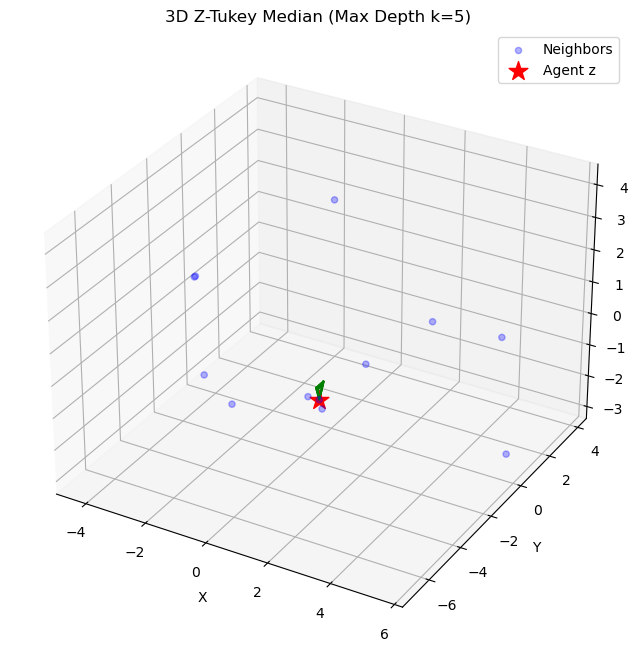

In [32]:
X = np.array(([0,-1,1], [3,2,2],[4.5, -2, -3], [2.2,4.3,6],[-2,-4,-5],[-3.5,3,4.5]))
np.random.seed(65)
X = np.random.randn(12, 3) * 3
tm, verts = ZTukeyMed3D(X,6)


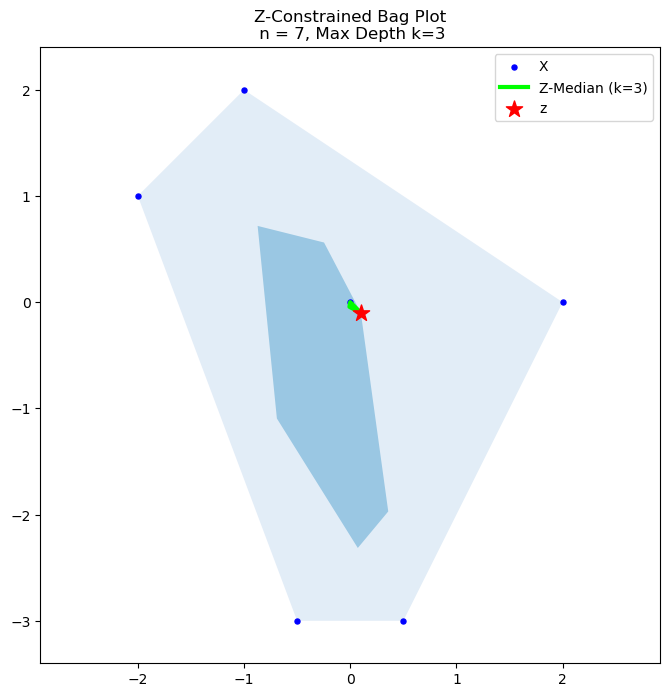

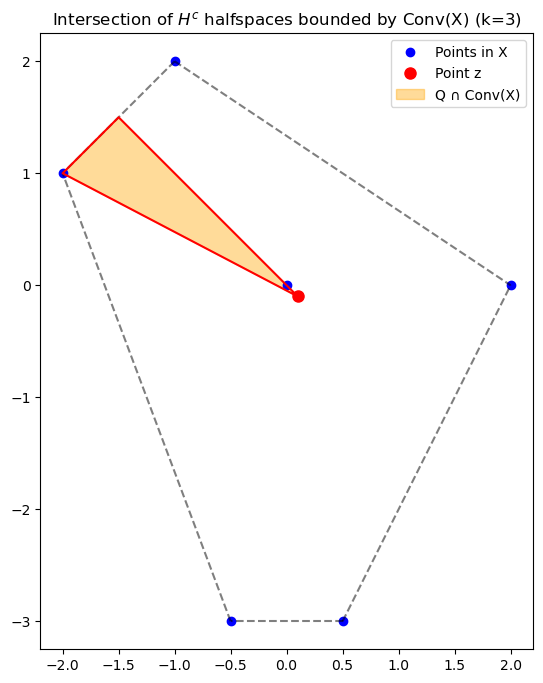

In [10]:
X = np.array(([0,0],[-1,2],[0.1,-0.1],[-2,1],[2,0],[-.5,-3],[.5,-3]))
np.random.seed(65)
#X = np.random.randn(12, 3) * 3
ZBagPlot(X,2)
ZKLevel(X,2,3)
#tm, verts = ZTukeyMed3Dint(X,5)
#print(len(X[0,:]))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.spatial import ConvexHull, HalfspaceIntersection
from scipy.optimize import linprog
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def ZTukeyMed3Dint(X, z_idx, plot=True):
    """
    Finds the largest k where the intersection of ConvexHull(Q) for all Q 
    (where |Q|=k and z in Q) is non-trivial (>1 vertex).
    """
    z = X[z_idx]
    n = len(X)
    
    # Start checking from k = n/2 down to 4 (k<4 in 3D makes flat hulls)
    start_k = int(n / 2)
    indices = [i for i in range(n) if i != z_idx]
    
    found_k = 0
    final_vertices = np.array([])
    
    print(f"Starting search at k={start_k} for n={n}...")

    for k in range(start_k, n-1, +1):
        print(f"Checking k={k}...")
        
        all_equations = []
        
        # 1. Generate all subsets Q of size k containing z
        # We pick k-1 neighbors + z
        for combo in combinations(indices, k - 1):
            subset_idxs = list(combo) + [z_idx]
            Q = X[subset_idxs]
            
            # 2. Compute Convex Hull of Q
            # NOTE: We need 4 points to define a 3D volume hull. 
            # If points are coplanar, ConvexHull raises error.
            try:
                hull = ConvexHull(Q)
                # hull.equations returns [a, b, c, d] where ax+by+cz+d <= 0 is interior
                all_equations.append(hull.equations)
            except Exception:
                # If a subset is degenerate (flat), we skip it or strict constraints would imply
                # restricting to that plane. For this robust search, we often skip degenerate hulls.
                continue
        
        if not all_equations:
            continue
            
        # Stack all inequalities from all subsets
        # We want the intersection of ALL these halfspaces
        big_eqs = np.vstack(all_equations)
        
        # 3. Find an interior point for HalfspaceIntersection using Linear Programming
        # We maximize slack 's' such that: Ax + s*||Ai|| <= -b
        hs_A = big_eqs[:, :3]
        hs_b = big_eqs[:, 3]
        
        # Calculate norms for slack variables (Chebyshev center formulation)
        norms = np.linalg.norm(hs_A, axis=1)
        
        # Objective: Maximize s (minimize -s). Variables: [x, y, z, s]
        # Constraints: Ax + s*||A|| <= -b  =>  Ax + s*||A|| <= -b
        c_obj = [0, 0, 0, -1] 
        
        A_lp = np.hstack([hs_A, norms.reshape(-1, 1)])
        b_lp = -hs_b
        
        # Bounds: x,y,z unbounded; s >= 0 (strictly >0 for volume)
        res = linprog(c_obj, A_ub=A_lp, b_ub=b_lp, bounds=[(None, None)]*3 + [(0, None)], method='highs')
        
        valid_region = False
        
        if res.success:
            center_point = res.x[:3]
            slack = res.x[3]
            
            # If slack is very close to 0, the region has collapsed to a point (likely z) or is flat
            # We look for a region with some volume or distinct vertices
            if slack > 1e-6:
                try:
                    # 4. Compute the actual intersection polytope
                    hs_int = HalfspaceIntersection(big_eqs, center_point)
                    verts = hs_int.intersections
                    
                    # 5. Check user condition: > 1 vertex
                    if len(verts) > 1:
                        final_vertices = verts
                        found_k = k
                        valid_region = True
                        break # Found the largest k!
                except Exception:
                    pass
        
        if valid_region:
            break

    # --- PLOTTING ---
    if plot:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot Neighbors
        ax.scatter(X[:,0], X[:,1], X[:,2], c='blue', alpha=0.3, label='Points X')
        # Plot Z
        ax.scatter(z[0], z[1], z[2], c='red', marker='*', s=200, label='Z', zorder=10)
        
        if found_k > 0 and len(final_vertices) > 1:
            try:
                # Draw the intersection polytope
                # We use ConvexHull of the vertices to get the correct face order for plotting
                hull_draw = ConvexHull(final_vertices)
                
                # Plot edges
                for simplex in hull_draw.simplices:
                    ax.plot(final_vertices[simplex, 0], final_vertices[simplex, 1], final_vertices[simplex, 2], 'g-', linewidth=2)
                
                # Plot faces
                faces = [final_vertices[s] for s in hull_draw.simplices]
                poly3d = Poly3DCollection(faces, alpha=0.3, facecolors='lime', edgecolors='green')
                ax.add_collection3d(poly3d)
                
                title_txt = f"Intersection of all Hulls (Size k={found_k})\nVertices: {len(final_vertices)}"
            except Exception:
                # Fallback for degenerate shapes (lines/flat polys)
                ax.plot(final_vertices[:,0], final_vertices[:,1], final_vertices[:,2], 'g-o', markersize=5)
                title_txt = f"Intersection found (Degenerate/Flat) k={found_k}"
        else:
            title_txt = "No intersection with volume found (>1 vertex)"

        ax.set_title(title_txt)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # Scale view
        all_pts = np.vstack([X, final_vertices]) if len(final_vertices) > 0 else X
        ax.set_xlim(all_pts[:,0].min(), all_pts[:,0].max())
        ax.set_ylim(all_pts[:,1].min(), all_pts[:,1].max())
        ax.set_zlim(all_pts[:,2].min(), all_pts[:,2].max())
        
        plt.legend()
        plt.show()

    return found_k, final_vertices

# --- USAGE EXAMPLE ---
# Create 12 random points in 3D


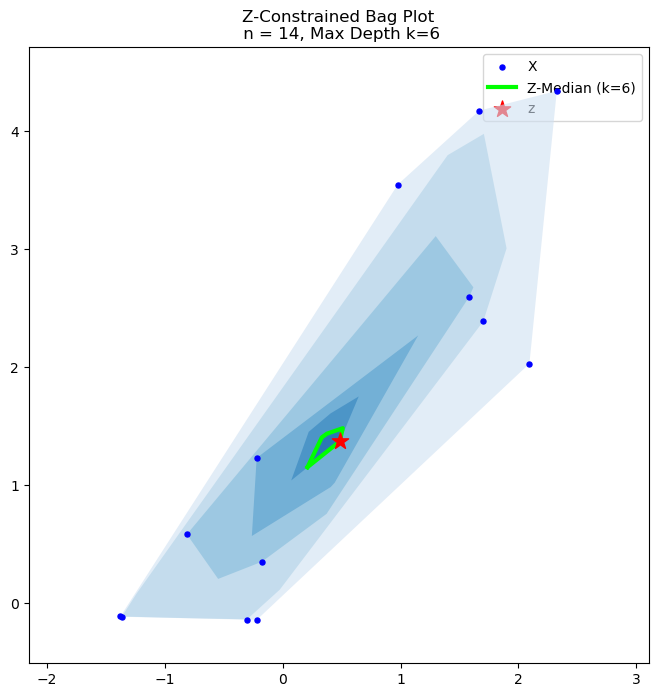

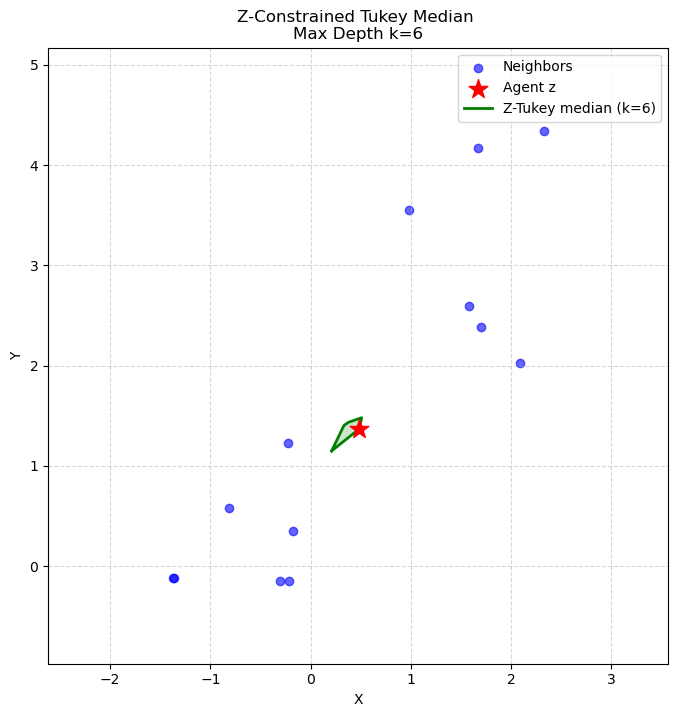

[[0.21050335 1.1491606 ]
 [0.48462689 1.36790717]
 [0.4846269  1.3679072 ]
 [0.50991745 1.47986708]
 [0.37621065 1.43361254]
 [0.33236944 1.40210613]]


In [14]:
step = 50
X= np.vstack([history_N[step], history_F[step]])
#plot_robust_collapse_check(X, 0, 2)
ZBagPlot(X,0)
#TukeyMed(X,True)
depth, verts = ZTukeyMed(X,0,True)
print(verts)

#PlotBoundedCells(X)
plt.show()

In [28]:
step = 300
X= np.vstack([history_N[step], history_F[step]])
PlotBoundedCells(history_N[step],history_F[step],6, ax=None, xlimits =3, ylimits =5)

TypeError: PlotBoundedCells() got multiple values for argument 'ax'

In [13]:
step = 1
X= np.vstack([history_N[step], history_F[step]])
print(history_N[0])
#PlotBoundedCells(history_N[step],history_F[step],6, ax=None)

[[-1.62373111 -0.10178393 -1.8097911 ]
 [ 0.26265384  0.25995268 -0.38108638]
 [-0.00228986  0.34161518  0.89757225]
 [-0.36110011  1.65644538 -1.1890092 ]
 [ 1.66642853 -2.00343926 -0.47787271]
 [ 1.36879857  0.25816851  0.7023519 ]
 [ 0.88838184  0.72221981 -1.38210273]
 [-0.99345464 -0.16946589  0.28797984]]


In [2]:
def ZKLevel(X, i, k):
    """
    Finds lines through z=X[i] and another point in X bounding exactly k-1 points,
    computes the intersection Q of their opposite halfspaces H^c, and plots Q ∩ Conv(X).
    """
    n = len(X)
    z = X[i]
    
    # Store halfspaces in the form a*x + b*y <= c
    # as lists of [a, b, c]
    halfspaces = []
    
    # 1. Identify valid lines and collect the H^c halfspaces
    for j in range(n):
        if i == j:
            continue
        
        # Direction vector from z to X[j]
        d = X[j] - z
        # Normal vector to the line (90 degree rotation)
        n_vec = np.array([-d[1], d[0]])
        
        # Dot products to determine which side of the line the points lie
        tol = 1e-9
        dots = np.dot(X - z, n_vec)
        
        c_pos = np.sum(dots > tol)
        c_neg = np.sum(dots < -tol)
        
        # If exactly k-1 points are strictly in the positive halfspace H
        if c_pos == k - 1:
            # H^c is the negative halfspace: n_vec * (x - z) <= 0
            # Formatted as: n_vec_x * x + n_vec_y * y <= n_vec * z
            halfspaces.append([n_vec[0], n_vec[1], np.dot(n_vec, z)])
            
        # If exactly k-1 points are strictly in the negative halfspace H
        if c_neg == k - 1:
            # H^c is the positive halfspace: -n_vec * (x - z) <= 0
            halfspaces.append([-n_vec[0], -n_vec[1], -np.dot(n_vec, z)])
            
    # 2. Add the Convex Hull of X to the halfspaces to bound Q
    hull = ConvexHull(X)
    for eq in hull.equations:
        # hull.equations format is ax + by + c <= 0. 
        # Rearrange to ax + by <= -c
        halfspaces.append([eq[0], eq[1], -eq[2]])
        
    halfspaces = np.array(halfspaces)
    
    # 3. Formulate Linear Program to find a strictly interior point (Chebyshev center)
    # Objective: maximize r (minimum distance to the halfspace boundaries)
    # subject to A*x + r*||A|| <= b
    norm_A = np.linalg.norm(halfspaces[:, :2], axis=1)
    
    # Minimize -r
    c_lp = np.array([0, 0, -1])
    A_ub = np.column_stack((halfspaces[:, :2], norm_A))
    b_ub = halfspaces[:, 2]
    
    # x and y are unbounded, r >= 0
    bounds = [(None, None), (None, None), (0, None)]
    res = linprog(c_lp, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    
    # 4. Plotting Setup
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.plot(X[:, 0], X[:, 1], 'o', color='blue', label='Points in X')
    ax.plot(z[0], z[1], 'o', color='red', markersize=8, label='Point z')
    
    for simplex in hull.simplices:
        ax.plot(X[simplex, 0], X[simplex, 1], 'k--', alpha=0.5)
        
    # 5. Compute and plot the intersection if a valid interior point exists
    if res.success and res.x[2] > 1e-7:
        interior_point = res.x[:2]
        
        # Format for HalfspaceIntersection: ax + by + c <= 0
        hs_input = np.column_stack((halfspaces[:, :2], -halfspaces[:, 2]))
        
        try:
            hs = HalfspaceIntersection(hs_input, interior_point)
            
            # Extract vertices and sort them counter-clockwise to draw a clean polygon
            v = hs.intersections
            center = np.mean(v, axis=0)
            angles = np.arctan2(v[:, 1] - center[1], v[:, 0] - center[0])
            v_sorted = v[np.argsort(angles)]
            
            # Close the loop
            v_sorted = np.vstack((v_sorted, v_sorted[0]))
            
            ax.fill(v_sorted[:, 0], v_sorted[:, 1], color='orange', alpha=0.4, label='Q ∩ Conv(X)')
            ax.plot(v_sorted[:, 0], v_sorted[:, 1], 'r-', linewidth=1.5)
            
        except Exception as e:
            print(f"Could not compute halfspace intersection geometrically: {e}")
    else:
        print("Intersection Q is empty or degenerate (a single point/line segment).")
        
    ax.set_aspect('equal')
    ax.legend()
    ax.set_title(f"Intersection of $H^c$ halfspaces bounded by Conv(X) (k={k})")
    plt.show()

Running Simulation (300 steps)...
Generating Animation...
Saving to zbagplot_animation_mpl3.gif...
Done.


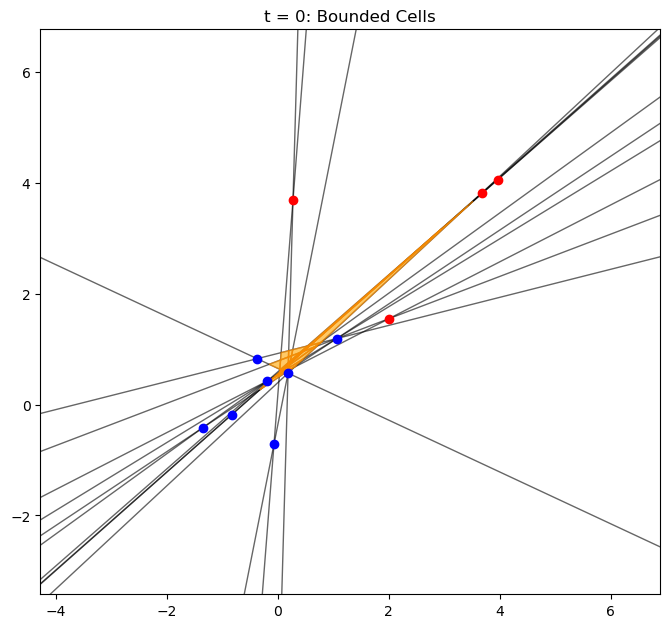

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial import ConvexHull
from itertools import combinations

# Import your ZBagPlot function
# Assuming zbagplot.py is in the same directory. 
# If not, paste the ZBagPlot function here.


# --- 1. Core Functions (ZTukeyMed & Update Logic) ---


NUM_STEPS = 300
STEP_SIZE = 0.01

normal = 7
adversarial = 4 
n = normal + adversarial

N_nodes = np.random.randn(normal, 2) * 1
F_nodes = np.random.randn(adversarial, 2) *1.5 + np.array([3.5, 3.0]) 
#N_nodes = np.array([(-4,0),(-5,0.2),(-5,-1),(-4,-.8), (4,0), (5,0.1),(4,-1),(5,-.8)])
#F_nodes = np.array([(1,1),(0.6,1.5),(-1,1),(-0.6, 1.5)])
# History storage
history_N = [N_nodes.copy()]
history_F = [F_nodes.copy()]
adv_target = np.array(([0.0, 4.0],[2.0,6.0],[0,6.1]))
# --- 3. Run Simulation Loop (Pre-calculate Data) ---
print(f"Running Simulation ({NUM_STEPS} steps)...")

for t in range(NUM_STEPS):
    current_N = history_N[-1]
    current_F = history_F[-1]
    all_positions = np.vstack([current_N, current_F])
    
    # Update Normal
    next_N = update_resilient_layers(current_N, all_positions, STEP_SIZE, STEP_SIZE*2)

    # Update Adversarial (Static for now based on your code)
    next_F = []
    for i in range(len(current_F)):
        next_F.append(current_F[i])
        #next_F.append(current_F[i] + (adv_target[1]-current_F[i])*STEP_SIZE*1.5)
    history_N.append(np.array(next_N))
    history_F.append(np.array(next_F))

history_N = np.array(history_N)
history_F = np.array(history_F)

# --- 4. Animation using Matplotlib ---
print("Generating Animation...")

fig, ax = plt.subplots(figsize=(8, 8))
plt.xlim(-4,4)
plt.ylim(-4,4)
# Define the frames we want (every 5th step)
plot_indices = range(0, NUM_STEPS + 1,3)

def update_plot(frame_idx):
    """
    Animation callback.
    frame_idx is the actual time step t from the simulation.
    """
    ax.clear() # Clear previous frame
    
    # Retrieve data for this step
    curr_N = history_N[frame_idx]
    curr_F = history_F[frame_idx]
    all_pos = np.vstack([curr_N, curr_F])
    
    # Agent 0 is the 0-th element of all_pos
    # ZBagPlot handles the plotting internally on the provided axis 'ax'
    # It sets titles, limits, and draws the bagplot.
    #max_k, _ = ZBagPlot(all_pos, 0, ax=ax, plot=True)
    faces = PlotBoundedCells(curr_N,curr_F,ax = ax)
    # We can override the title if we want to add the step count
    ax.set_title(f"t = {frame_idx}: Bounded Cells")
    #ax.set_xlim(-7,7)
    #ax.set_ylim(-7,7)
    if frame_idx == 0:
        plt.savefig("Zmed_bounded_cells_t0.png")
    if frame_idx == 300:
        plt.savefig("Zmed_bounded_cells_t300.png")
# Create Animation object
# frames iterator yields the specific steps (0, 5, 10...)
ani = animation.FuncAnimation(fig, update_plot, frames=plot_indices, interval=100)

# Save as GIF
output_file = "zbagplot_animation_mpl3.gif"
print(f"Saving to {output_file}...")
ani.save(output_file, writer='pillow', fps=5)

print("Done.")

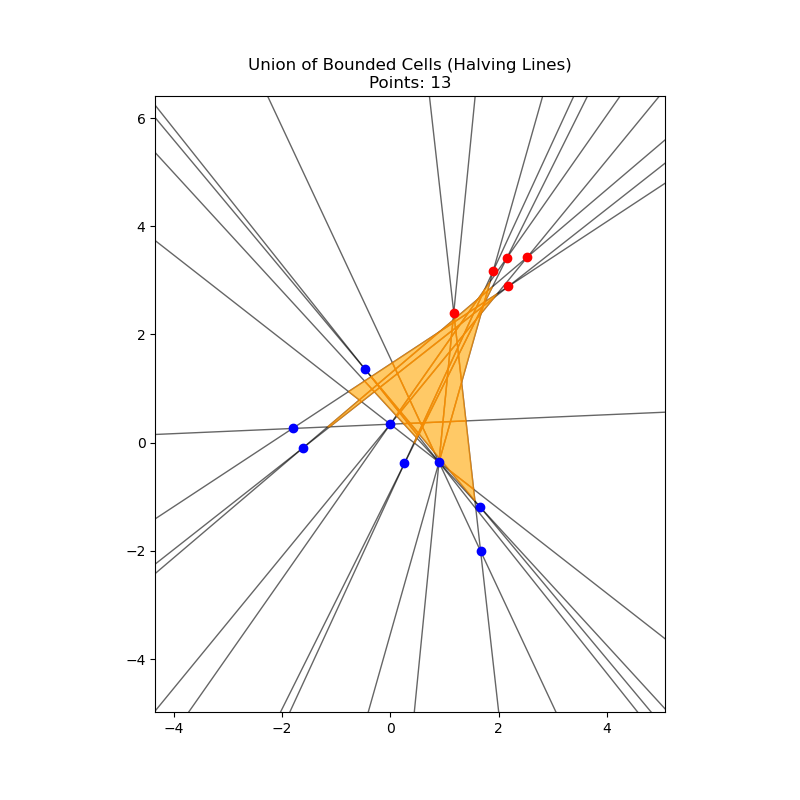

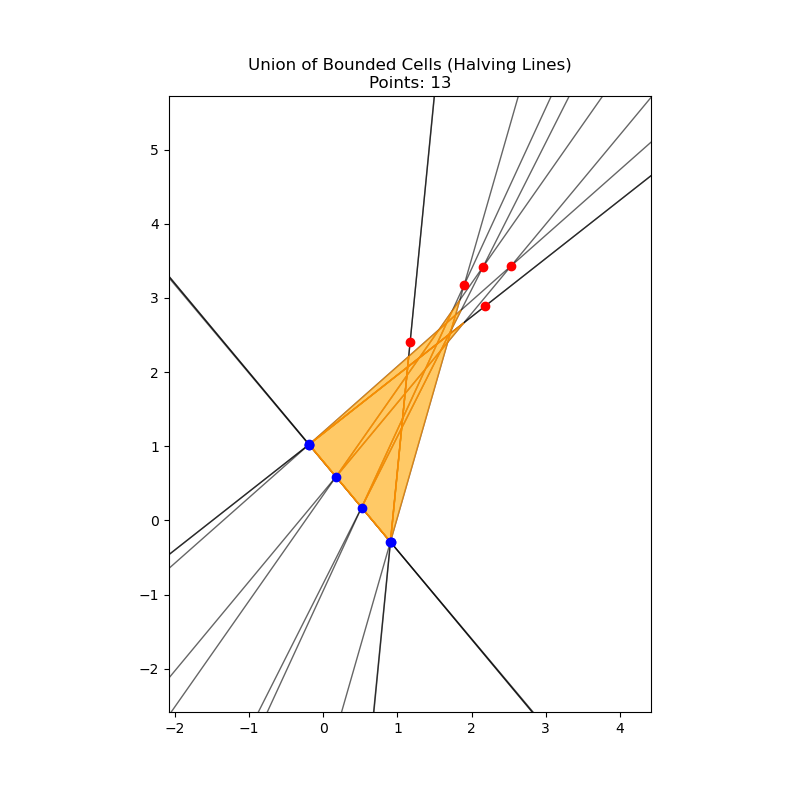

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.xlim(-4,4)
plt.ylim(-4,4)
faces0 = PlotBoundedCells(history_N[0],history_F[0],ax = ax)
plt.show()
fig2, ax2 = plt.subplots(figsize=(8, 8))
plt.xlim(-4,4)
plt.ylim(-4,4)
faces = PlotBoundedCells(history_N[299],history_F[299],ax = ax2)
plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from itertools import combinations

# 1. Setup Points
n = 8
#np.random.seed(42)
# Generate points (mixture of circle and random interior to create structure)
angles = np.linspace(0, 2*np.pi, n, endpoint=False)
radii = np.random.uniform(0.8, 1.2, n)
points = np.array([radii * np.cos(angles), radii * np.sin(angles)]).T
points = points + np.random.normal(0, 0.1, points.shape) # Noise
points = np.array([(-8,1),(-8,0),(-1,8),(
# 2. Identify Halving Lines
# A line through 2 points is halving if it leaves (n-2)/2 points on each side.
halving_lines = []
target = (n - 2) // 2

def get_line(p1, p2):
    # Ax + By + C = 0
    A = p1[1] - p2[1]
    B = p2[0] - p1[0]
    C = -A*p1[0] - B*p1[1]
    return A, B, C

for i, j in combinations(range(n), 2):
    p1, p2 = points[i], points[j]
    A, B, C = get_line(p1, p2)
    # Check split
    vals = A*points[:,0] + B*points[:,1] + C
    if np.sum(vals > 1e-9) == target and np.sum(vals < -1e-9) == target:
        halving_lines.append((A, B, C))

# 3. Compute V (Convex Hull of Intersections)
# The union of bounded cells is the polygon formed by the "outermost" intersections of the lines.
intersections = []
for l1, l2 in combinations(halving_lines, 2):
    A1, B1, C1 = l1
    A2, B2, C2 = l2
    det = A1*B2 - A2*B1
    if abs(det) > 1e-10:
        x = (B1*C2 - B2*C1) / det
        y = (C1*A2 - C2*A1) / det
        intersections.append([x, y])
intersections = np.array(intersections)

# Compute Convex Hull of intersections to represent V
if len(intersections) > 0:
    hull_V = ConvexHull(intersections)
    verts_V = intersections[hull_V.vertices]
    area_V = hull_V.volume
else:
    area_V = 0

# Compute Convex Hull of Points
hull_pts = ConvexHull(points)
area_pts = hull_pts.volume

print(f"Ratio Area(V) / Area(CH): {area_V / area_pts:.4f}")

Ratio Area(V) / Area(CH): 0.0064


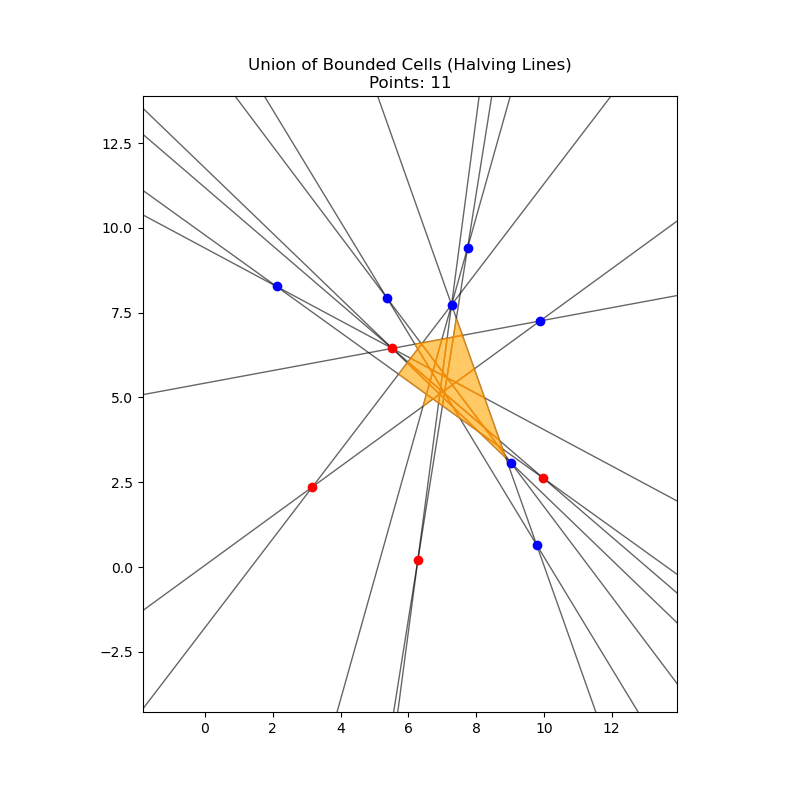

In [3]:
# Enable interactive backend for Jupyter Lab
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton

# Import your helper function


class InteractiveBoundedCells:
    def __init__(self, n_points=11):
        self.n = n_points
        
        # Initialize random points (0-10 range)
        self.split_idx = 7
        self.points = np.random.rand(n_points, 2) * 10 
        
        # State variable for selection
        self.selected_idx = None
        
        # Setup Figure and Axis
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.fig.canvas.header_visible = False 
        
        # Connect Event Listener (Only need 'button_press_event' now)
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        
        # Initial Plot
        self.update_plot()
        plt.show()

    def update_plot(self):
        """Clears the axis and runs the custom PlotBoundedCells logic."""
        self.ax.clear()
        
        # 1. Split points into Normal (Blue) and Faulty (Red)
        X_n = self.points[:self.split_idx]
        X_f = self.points[self.split_idx:]
        
        # 2. Call your custom geometry function
        try:
            PlotBoundedCells(X_n, X_f, ax=self.ax)
        except Exception as e:
            print(f"Geometric calculation error: {e}")

        # 3. Add a highlight circle if a point is currently selected
        if self.selected_idx is not None:
            selected_point = self.points[self.selected_idx]
            # Draw a yellow halo around the selected point
            self.ax.scatter(selected_point[0], selected_point[1], 
                            s=300, facecolors='none', edgecolors='yellow', 
                            linewidth=3, label='Selected', zorder=100)
            self.ax.text(selected_point[0], selected_point[1]+0.3, "Selected", 
                         color='black', ha='center', fontweight='bold', zorder=101)

        self.fig.canvas.draw()

    def on_press(self, event):
        """Handle mouse clicks."""
        if event.inaxes != self.ax:
            return
        
        # Only handle left clicks
        if event.button is MouseButton.LEFT:
            
            # CASE A: No point selected -> Try to select one
            if self.selected_idx is None:
                # Find closest point
                xy = np.asarray(self.points)
                d = np.sqrt(np.sum((xy - [event.xdata, event.ydata])**2, axis=1))
                
                # Selection threshold (0.5 units)
                ind_seq = np.nonzero(d < 0.5)[0]
                
                if len(ind_seq) > 0:
                    self.selected_idx = ind_seq[0]
                    # Redraw to show the selection highlight
                    self.update_plot()
            
            # CASE B: Point already selected -> Move it here
            else:
                self.points[self.selected_idx] = [event.xdata, event.ydata]
                self.selected_idx = None # Deselect
                self.update_plot()

# Instantiate the interactive plot
app = InteractiveBoundedCells(n_points=11)